In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import parallel_backend
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree

In [ ]:
file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path)

In [ ]:
# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

# Step 3: Outlier Detection and Treatment using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

Missing values in each column:
 Unnamed: 0              0
GridId                  0
Toid                    0
GRID_ExactCut_ID        0
Location_ExactCut       0
BoroughName_ExactCut    0
Lts                     0
Length (m)              0
Emissions               0
Year                    0
Pollutant               0
Emissions Unit          0
VehicleType             0
Emission Value          0
RowID                   0
TLRN                    0
MotorwayNumber          0
Speed (kph)             0
AADT                    0
VKM                     0
dtype: int64


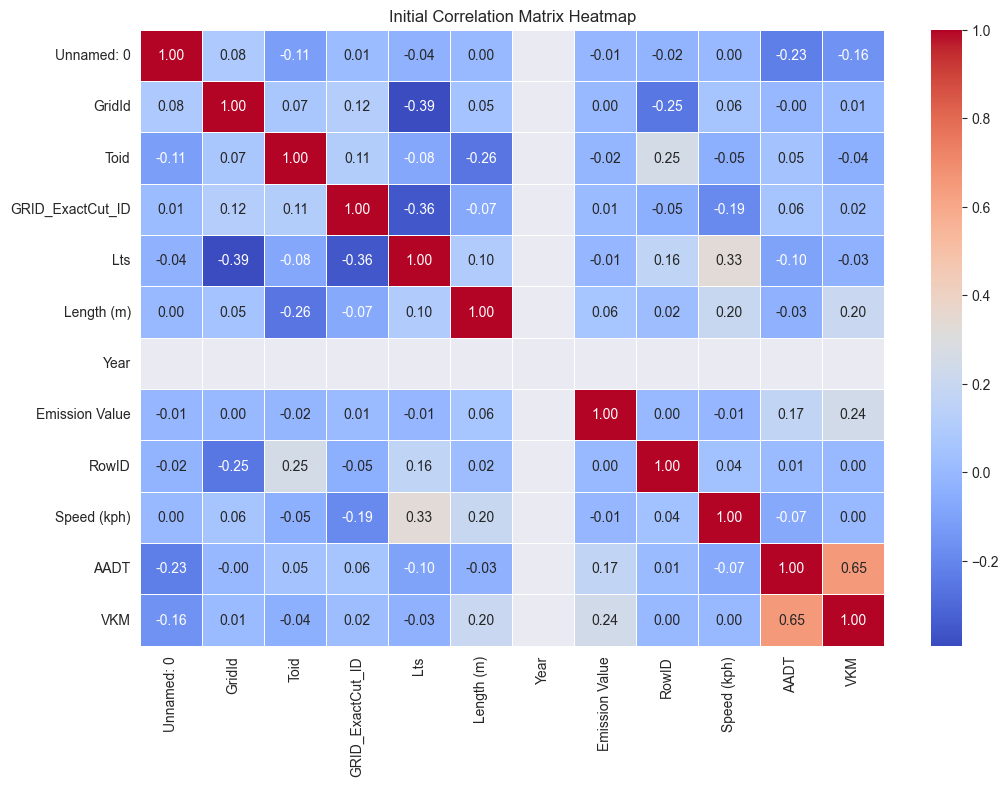

In [ ]:
# Initial heatmap of the correlation matrix
initial_correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Initial Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Encode categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'Pollutant', 'Emissions Unit', 'VehicleType', 'TLRN']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

# Calculate correlation matrix after encoding
encoded_correlation_matrix = df.corr()

# Correlation with the target variable
target_corr = encoded_correlation_matrix['Emission Value'].abs().sort_values(ascending=False)
print(target_corr)

Emission Value          1.000000
Emissions               0.246327
VKM                     0.240336
AADT                    0.168744
Pollutant               0.129420
Length (m)              0.059867
VehicleType             0.023273
Toid                    0.015770
Unnamed: 0              0.010218
Speed (kph)             0.010004
Lts                     0.009858
GRID_ExactCut_ID        0.005572
BoroughName_ExactCut    0.005439
Location_ExactCut       0.001253
TLRN                    0.001033
RowID                   0.000819
GridId                  0.000676
Year                         NaN
Emissions Unit               NaN
Name: Emission Value, dtype: float64


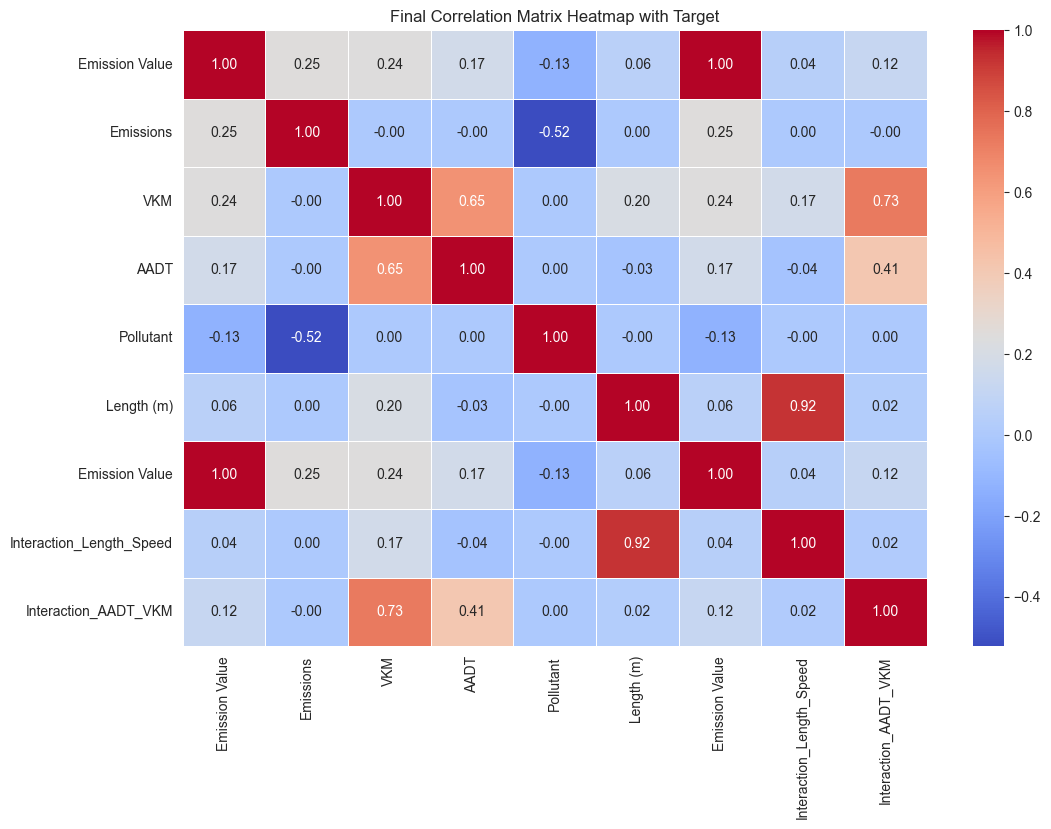

In [ ]:
# Select features with correlation greater than 0.05
selected_features = target_corr[target_corr > 0.05].index.tolist()

# Add the target variable back to the selected features
selected_features.append('Emission Value')

df['Interaction_Length_Speed'] = df['Length (m)'] * df['Speed (kph)']
df['Interaction_AADT_VKM'] = df['AADT'] * df['VKM']

# Redefine features and preprocess again
selected_features = selected_features + ['Interaction_Length_Speed', 'Interaction_AADT_VKM']

# Plot final heatmap with Emission Value
final_correlation_matrix_with_target = df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap with Target')
plt.show()

In [ ]:
# Final dataset with selected features, drop 'Emission Value' for training features
X = df[selected_features].drop(columns=['Emission Value'])
y = df['Emission Value']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

   Emissions       VKM      AADT  Pollutant  Length (m)  \
0   3.000000 -0.023502  0.095732  -1.566699   -0.327321   
1  -0.333333 -0.023502  0.095732  -1.218544   -0.327321   
2  -0.333333 -0.023502  0.095732  -0.870388   -0.327321   
3  -0.333333 -0.023502  0.095732  -0.522233   -0.327321   
4  -0.333333 -0.023502  0.095732  -0.174078   -0.327321   

   Interaction_Length_Speed  Interaction_AADT_VKM  
0                 -0.117514              -0.02785  
1                 -0.117514              -0.02785  
2                 -0.117514              -0.02785  
3                 -0.117514              -0.02785  
4                 -0.117514              -0.02785  


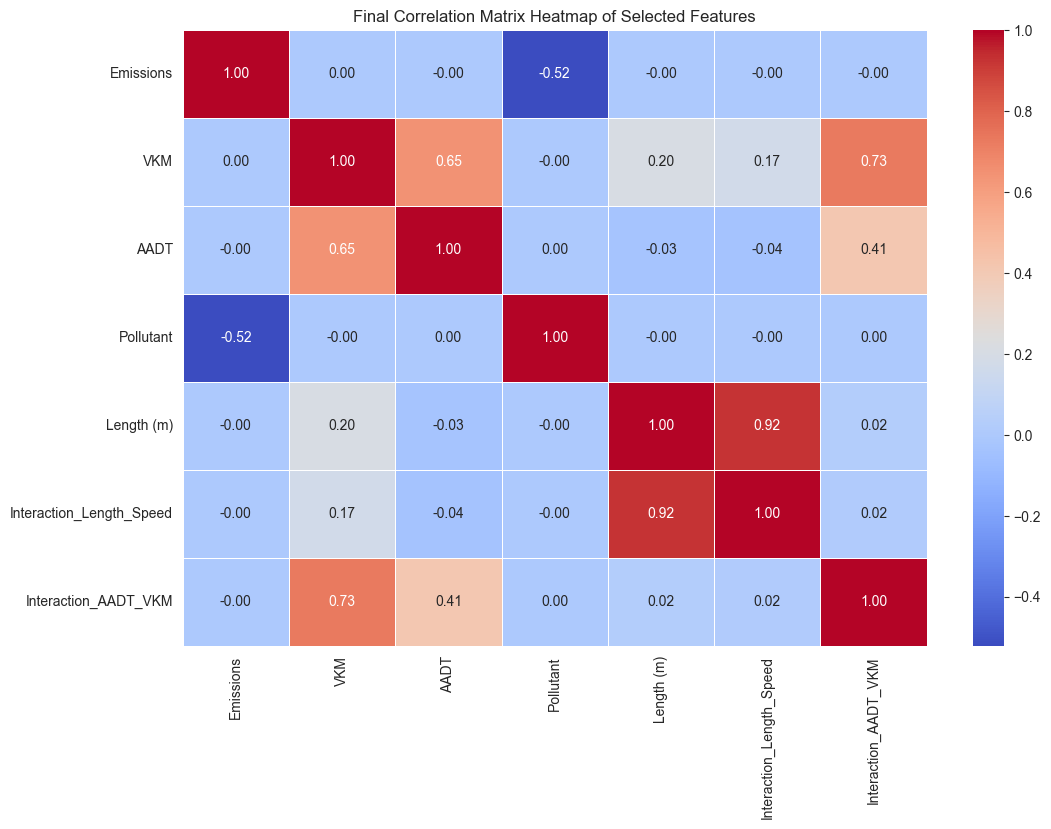

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Final heatmap of the correlation matrix without the target
final_correlation_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap of Selected Features')
plt.show()

In [ ]:
# The dataset is now ready for ML training
dataset_info = {
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
    "features": selected_features[:-1],  # exclude the target from features
    "target": 'Emission Value'
}

print(dataset_info)

{'X_train_shape': (2695296, 7), 'X_test_shape': (673824, 7), 'y_train_shape': (2695296,), 'y_test_shape': (673824,), 'features': ['Emission Value', 'Emissions', 'VKM', 'AADT', 'Pollutant', 'Length (m)', 'Emission Value', 'Interaction_Length_Speed'], 'target': 'Emission Value'}


In [ ]:
# Train and evaluate Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

In [ ]:
# Define and test a few hyperparameter combinations
rf1 = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

rf2 = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

In [ ]:
# Define the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_nn = nn_model.predict(X_test).flatten()

Epoch 1/50
52593/67383 [======================>.......] - ETA: 10s - loss: 0.9390

KeyboardInterrupt: 

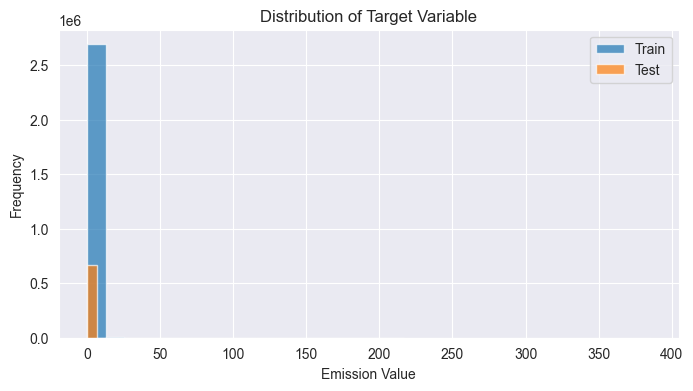

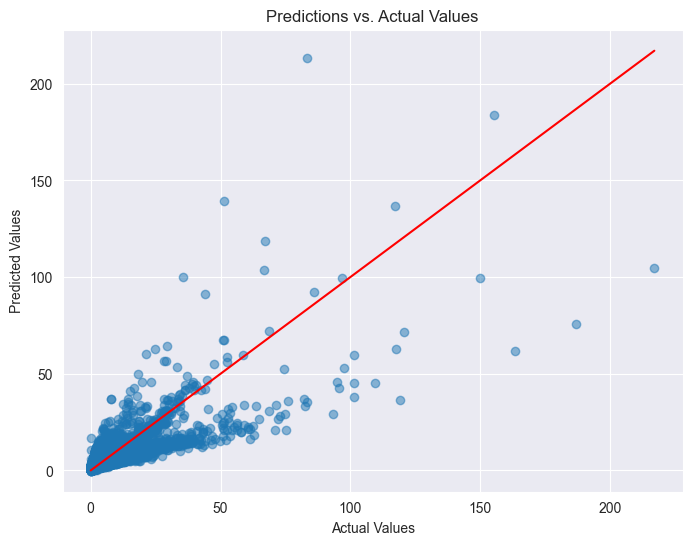

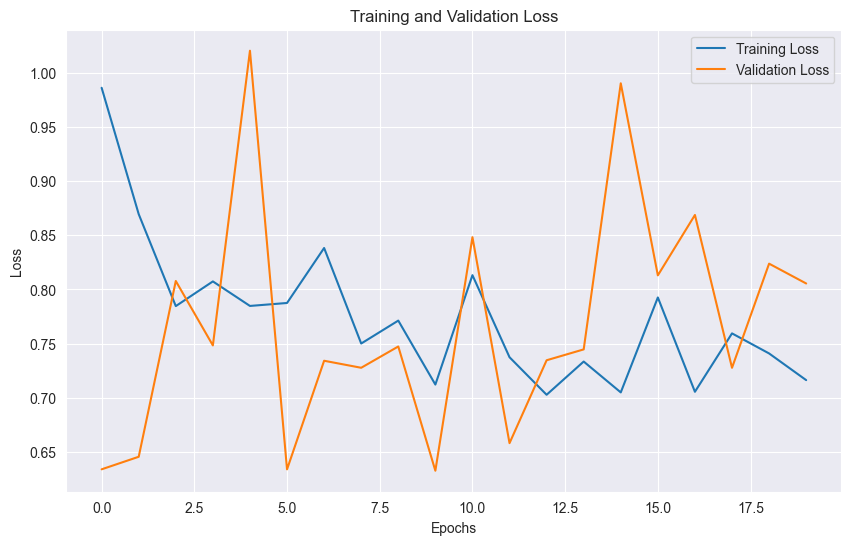

In [ ]:
# Plot the distribution of target values
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.title('Distribution of Target Variable')
plt.xlabel('Emission Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate Models
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

linear_metrics = evaluate_model(y_test, y_pred_lr)
rf1_metrics = evaluate_model(y_test, y_pred_rf1)
rf2_metrics = evaluate_model(y_test, y_pred_rf2)

nn_metrics = evaluate_model(y_test, y_pred_nn)

print("Linear Regression Metrics (MAE, MSE, R^2):", linear_metrics)
print("Random Forest Metrics (MAE, MSE, R^2):", rf1_metrics)
print("Random Forest Metrics (MAE, MSE, R^2):", rf2_metrics)
print("Neural Network Metrics (MAE, MSE, R^2):", nn_metrics)

Linear Regression Metrics (MAE, MSE, R^2): (0.2723747597630134, 1.5748793867253497, 0.1172551101662892)
Random Forest Metrics (MAE, MSE, R^2): (0.06891174318455733, 0.5901711685386091, 0.66919969392837)
Random Forest Metrics (MAE, MSE, R^2): (0.061712402110845915, 0.5353381419706822, 0.6999344755281209)
Neural Network Metrics (MAE, MSE, R^2): (0.11979090672927525, 0.580570569940574, 0.674580981805521)
